# 1. Electricity Consumption Dataset Preparation

The dataset chosen for analysis is the Electricity Consumption dataset from Ireland, provided by the Commission for Energy Regulation (CER) as part of the CER Smart Metering initiative. This publicly available dataset captures electricity consumption and is updated twice an hour, resulting in 48 entries per day.

## Project Background

The dataset is sourced from the "Electricity Customer Behaviour Trial, 2009-2010, 1st Edition," archived by the Irish Social Science Data Archive in 2012. The data is publicly accessible at [this URL](https://www.ucd.ie/issda/data/commissionforenergyregulationcer/).

## Dataset Details

- **File Structure:** Six zipped files (File1.txt.zip to File6.txt.zip), each containing a single text file.
- **Data Format:** Each data file consists of three columns:
  1. Meter ID
  2. Five-digit code
  3. Day code (digits 1-3, with day 1 corresponding to January 1, 2009)
  4. Time code (digits 4-5, representing 30-minute intervals from 00:00:00 to 00:29:59)
  5. Electricity consumed during the 30-minute interval (in kWh)

### Unify Data :
This code aims to concatenate multiple text files into a single one. It defines a list called `files` containing the names of the files to be concatenated. The result of the concatenation will be saved in a new file named `FileData`.

In [ ]:
# List of input files to be concatenated
files = ['File1.txt', 'File2.txt', 'File3.txt', 'File4.txt', 'File5.txt', 'File6.txt']

# Output file where the concatenated data will be saved
output_file = 'FileData.txt'

# Function to concatenate files
def concatenate_files(input_files, output_file):
    # Open the output file in write mode
    with open(output_file, 'w') as output:
        # Iterate through each input file
        for file in input_files:
            # Open the current input file in read mode
            with open(file, 'r') as f:
                # Read the content of the input file
                content = f.read()
                # Write the content to the output file
                output.write(content)

# Call the function to concatenate files
concatenate_files(files, output_file)

print('Files concatenated into', output_file)

In [34]:
# Show the output file content
with open('FileData.txt', 'r') as f:
    header_lines = [next(f) for _ in range(10)]
    header_preview = ''.join(header_lines)
    print(f'Preview of FileData.txt:\n{header_preview}')

Preview of FileData.txt:
1392 19503 0.14
1392 19504 0.138
1392 19505 0.14
1392 19506 0.145
1392 19507 0.145
1392 19501 0.157
1392 19502 0.144
1392 19724 0.128
1392 19725 0.142
1392 19726 0.145



### Clean Data :

The purpose of this code is to clean and process hourly household electricity consumption data. Each observation has 24 values corresponding to the 24-hour consumption of a consumer for a day.

In [1]:
# Import the required libraries
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Input and output files
input_file = 'FileData.txt'
output_file_raw = 'raw_data.csv'
output_file = 'final_data.csv'

# Dictionary to store the data
data = {}

# Read the input file and store the lines
with open(input_file, 'r') as file:
    lines = file.readlines()

# Process each line in the input file
for line in lines:
    # Split the line into three parts: ID, date, and consumption
    ID, date, consumption = line.split()

    # Extract day and hour information from the date
    day = int(date[:3])
    half_hour = int(date[3:5])
    hour = (half_hour - 1) // 2
    
    # Initialize the data dictionary if necessary
    if ID not in data:
        data[ID] = {}
    
    if day not in data[ID]:
        data[ID][day] = [0.0] * 24

    # Update the consumption information
    if 0 <= hour <= 23:
        data[ID][day][hour] += float(consumption) * 1000  # Convert kWh to Wh
         

In [4]:
# Write the data to a CSV file
with open(output_file_raw, 'w', newline='') as file:
    writer = csv.writer(file)

    # Header
    writer.writerow(['ID', 'Day', 'H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23'])
    
    # Write each row to the CSV file
    for ID, date_and_consumption in data.items():
        for day, consumption_list in date_and_consumption.items():
            # Join to combine the first two columns with spaces and the rest with commas
            row = [ID, day] + consumption_list
            writer.writerow(row)
            

Visualize all dataset before cleaning restrictions.

Number of unique users: 6435
Number of unique days: 536
Number of rows: 3291258


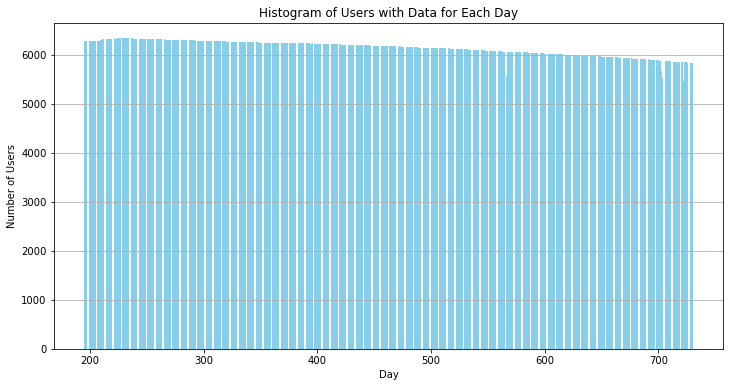

In [5]:
raw_data_df = pd.read_csv('raw_data.csv', delimiter=',', index_col=0)

print('Number of unique users:', len(raw_data_df.groupby('ID')))  # 6435
print('Number of unique days:', len(raw_data_df.groupby('Day')))  # 536
print('Number of rows:', len(raw_data_df))  # 3291258

# Group by day and count the number of users with data each day
daily_user_counts = raw_data_df.groupby('Day').size()

# Plot a histogram
plt.figure(figsize=(12, 6))
plt.bar(daily_user_counts.index, daily_user_counts, color='skyblue')
plt.title('Histogram of Users with Data for Each Day')
plt.xlabel('Day')
plt.ylabel('Number of Users')
plt.grid(axis='y')
plt.show()

The data preparation involves applying several filters suggested:

- All daily consumption associated with non-household consumers, defined as those with electricity consumption greater than 15 kWh at any hour of any day, has been removed.
- Observations where the consumption of any hour is missing have been removed.
- Observations with total daily consumption less than 100 W have been removed.

In [7]:
low_threshold = 100
high_threshold = 15000

# Identify IDs with daily consumption below the minimum threshold
IDs_below_threshold = {
    ID for ID, date_and_consumption in data.items()
    if any(sum(consumption_list) < low_threshold for day, consumption_list in date_and_consumption.items())
}

# Count the total number of days meeting the condition
total_days_below_threshold = sum(
    sum(sum(consumption_list) < low_threshold for day, consumption_list in date_and_consumption.items())
    for ID, date_and_consumption in data.items()
)

# Identify IDs with maximum consumption exceeding 15000 Wh in any hour
IDs_above_threshold = {
    ID for ID, date_and_consumption in data.items()
    if any(max(consumption_list) > high_threshold for day, consumption_list in date_and_consumption.items())
}

# Create a dictionary to store the cleaned data with all the filters applied
cleaned_data = {
    ID: {
        day: consumption_list
        for day, consumption_list in date_and_consumption.items()
        if all(hour_consumption != 0 for hour_consumption in consumption_list) and sum(consumption_list) > low_threshold
    }
    for ID, date_and_consumption in data.items()
    if ID not in IDs_above_threshold
}

# Create the CSV file
with open(output_file, 'w', newline='') as file:
    writer = csv.writer(file)
    # Header
    writer.writerow(['ID', 'Day', 'H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23'])
    
    # Write each row to the CSV file
    for ID, date_and_consumption in cleaned_data.items():
        for day, consumption_list in date_and_consumption.items():
            # Join to combine the first two columns with spaces and the rest with commas
            row = [ID, day] + consumption_list
            writer.writerow(row)

In [78]:
# Show the first few lines of the CSV file
final_data_df = pd.read_csv('final_data.csv', delimiter=',', index_col=0)
final_data_df.head(10)

,Day,H0,H1,H2,H3,H4,H5,H6,H7,H8,...,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23
ID,,,,,,,,,,,,,,,,,,,,,
1392,195,301.0,278.0,285.0,289.0,283.0,292.0,281.0,2093.0,270.0,...,275.0,299.0,325.0,503.0,815.0,493.0,489.0,327.0,276.0,277.0
1392,197,455.0,299.0,296.0,282.0,275.0,284.0,283.0,305.0,289.0,...,260.0,295.0,262.0,423.0,602.0,519.0,808.0,443.0,474.0,366.0
1392,198,275.0,276.0,297.0,291.0,274.0,272.0,274.0,294.0,280.0,...,296.0,280.0,440.0,754.0,928.0,710.0,508.0,470.0,450.0,426.0
1392,199,306.0,290.0,289.0,286.0,281.0,311.0,274.0,273.0,297.0,...,1474.0,2785.0,2822.0,3079.0,2500.0,950.0,697.0,440.0,2725.0,620.0
1392,200,303.0,299.0,478.0,1154.0,306.0,282.0,275.0,270.0,302.0,...,797.0,402.0,283.0,343.0,1304.0,2972.0,734.0,447.0,3933.0,776.0
1392,196,275.0,276.0,272.0,283.0,289.0,279.0,268.0,304.0,265.0,...,290.0,287.0,284.0,397.0,343.0,339.0,1048.0,2391.0,412.0,296.0
1392,202,365.0,291.0,304.0,274.0,281.0,301.0,268.0,652.0,290.0,...,259.0,290.0,269.0,429.0,461.0,447.0,924.0,1214.0,686.0,435.0
1392,201,511.0,379.0,289.0,269.0,304.0,268.0,285.0,299.0,282.0,...,266.0,287.0,255.0,292.0,256.0,289.0,269.0,535.0,737.0,579.0
1392,204,395.0,293.0,315.0,310.0,266.0,309.0,268.0,280.0,1635.0,...,500.0,535.0,530.0,591.0,539.0,1755.0,623.0,546.0,862.0,550.0


Now we visualize the number of users for each day when we have data.

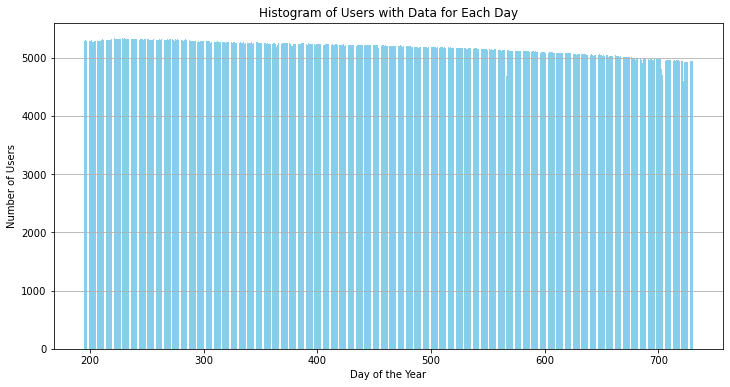

In [9]:
# Group by day and count the number of users with data each day
daily_user_counts = final_data_df.groupby('Day').size()

# Plot a histogram
plt.figure(figsize=(12, 6))
plt.bar(daily_user_counts.index, daily_user_counts, color='skyblue')
plt.title('Histogram of Users with Data for Each Day')
plt.xlabel('Day of the Year')
plt.ylabel('Number of Users')
plt.grid(axis='y')
plt.show()

The following code snippet prints various statistics related to the processed electricity consumption data. It provides insights into the distribution of users based on daily consumption and the duration of data available for each user.

In [10]:
print('Number of unique users:', len(final_data_df.groupby('ID')))  # 5483
print('Number of unique days:', len(final_data_df.groupby('Day')))  # 536
print('Number of rows:', len(final_data_df))  # 2772102

print('Number of users with more than 365 days of data:', (final_data_df.groupby('ID')['Day'].nunique() > 365).sum())  # 5118
print('Number of users with 365 days or fewer of data:', (final_data_df.groupby('ID')['Day'].nunique() <= 365).sum())  # 365

print('Number of users with daily consumption below 100 Wh:', len(IDs_below_threshold))  # 220
print('Total number of days with daily consumption below 100 Wh:', total_days_below_threshold)  # 15729
print('Number of users with maximum consumption above 15000 Wh:', len(IDs_above_threshold))  # 946


Number of unique users: 5483
Number of unique days: 536
Number of rows: 2772102
Number of users with more than 365 days of data: 5118
Number of users with 365 days or fewer of data: 365
Number of users with daily consumption below 100 Wh: 220
Total number of days with daily consumption below 100 Wh: 15729
Number of users with maximum consumption above 15000 Wh: 946


## Ireland Centroids Dataset Introduction

In addition to the cleaned electricity consumption data, this analysis incorporates information from the `ireland_centroids.csv` file. This file contains data related to 21 clusters, each representing specific patterns of electricity consumption throughout the day. The structure of the dataset consists of 21 rows, each corresponding to a cluster, and 24 columns, representing consumption values for each hour.

In [79]:
# Show the first few lines of the CSV file
centroids_data_df = pd.read_csv('ireland_centroids.csv', delimiter=';', index_col=0)
centroids_data_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,"666,4047989","484,3348125","403,4958508","370,5242449","363,9956877","391,1225584","496,1064019","659,0533093","732,2926146","661,01003",...,"623,648993","647,0500293","688,7326201","989,9681025","1397,614702","1526,123454","1467,507396","1424,304946","1277,736255","1007,610938"
1,"7988,886395","7268,747308","6804,774458","6640,175034","6434,407857","6337,863037","6328,513272","6650,202032","7212,943425","7726,617321",...,"9000,765661","8950,589565","9127,54664","9296,297133","9482,043076","9707,37919","9684,543","9512,932352","8907,892765","8432,035796"
2,"5063,535694","4365,20705","3896,869676","3597,825253","3459,254087","3456,880073","3567,784944","3849,556655","4187,166463","4334,573001",...,"4875,544757","5077,23446","5581,563883","6209,9434","6724,074224","7015,644223","7026,273768","6932,770822","6616,379795","5979,589681"
3,"664,6497172","484,2433837","403,5498548","369,6088678","362,3800528","393,0481233","495,5519526","690,8989463","841,4929344","824,3257151",...,"901,4974779","1392,202893","2653,601995","2977,45763","1610,71475","1378,719383","1351,973793","1336,130244","1202,78811","964,6787968"
4,"8317,068925","8494,768477","8141,301943","7593,319714","6861,971765","6048,787909","5365,844544","4482,354592","2397,45524","2033,887394",...,"2013,833416","1976,317721","1890,804684","1553,519349","1301,88291","1304,58379","1332,658196","1404,319548","1763,12772","5746,453081"
5,"320,9617805","255,8529408","229,0727803","219,6400323","219,8409737","230,3430188","278,9403452","365,1809808","400,5903171","395,7992008",...,"339,4813624","350,8468438","383,4553016","445,2390475","459,0560248","460,7941184","481,0623598","508,5717865","488,2140572","411,4321711"
6,"744,0340961","531,7281641","450,1618844","419,390594","413,7269154","434,3549074","511,5083006","770,9668765","2036,330275","4275,530081",...,"1008,030692","1040,889799","1179,394642","1439,467895","1541,921779","1564,426767","1509,727349","1470,473534","1314,84056","1037,554792"
7,"1601,166038","1170,655912","959,1443988","878,8354325","843,3342118","861,2455196","1003,845919","1423,54289","2003,284886","2671,094546",...,"4619,613355","4631,944016","4846,799617","5423,645287","5400,697082","4917,796205","4308,656827","3766,674","3124,94901","2392,107585"
8,"3143,240185","2796,657691","2539,800582","2408,069459","2377,959","2403,000597","2524,842335","2824,192953","2941,967984","2819,09906",...,"2571,329222","2558,569303","2656,323198","2854,969178","2976,304606","2999,867704","3070,49086","3190,848411","3166,725462","3052,212142"
9,"924,0087425","661,8933466","548,395662","500,1601065","487,6160346","507,3462142","590,9254691","818,7031271","1197,057764","1920,451723",...,"1424,847904","1408,849581","1557,612016","1876,667265","1996,534092","2021,527372","1928,341796","1826,092761","1607,998004","1261,050153"


### Assigning Centroids to Daily Consumption Profiles:

In this step, the code utilizes two datasets: `FinalData.csv`, which contains daily electricity consumption data for each user, and `ireland_centroids.csv`, representing 21 consumption patterns through centroids. The objective is to assign a centroid label to each daily consumption profile based on the closest match.

This code iteratively calculates the Euclidean distance between each daily consumption profile and the 21 centroids, assigning the closest centroid label to each row. The resulting dataset, `FinalData+Cluster.csv`, facilitates further analysis of electricity consumption patterns based on identified clusters.


### PODEMOS DESCARTAR ESTE CODIGO Y SIMPLEMENTE CREAR UN CSV CON: ID, Day, Centroid

In [119]:
# Add a column for the associated centroid to each consumption row
final_data_df['Centroid'] = np.nan

# Change decimal format of consumption columns
centroids_data_df = centroids_data_df.replace(',', '.', regex=True).astype(float)

# Iterate through each row in the consumption dataset
for i in range(len(final_data_df)):
    # Extract hourly consumption values from the row. row[1:-1] excludes the first and last columns: 'Day' and 'Centroid'
    consumption_array = np.array(final_data_df.iloc[i, 1:-1], dtype=float) # [hour_1, hour_2, ..., hour_24]

    # Calculate the Euclidean distance to each centroid
    distances = np.linalg.norm(centroids_data_df.values - consumption_array, axis=1)
    # distances = [distance_centroid_1, distance_centroid_2, ..., distance_centroid_21]
    
    # Assign the centroid with the lowest distance as letters A, B, C, ..., U
    final_data_df.iloc[i, -1] = chr(65 + int(np.argmin(distances)))

# Save the updated dataset with assigned centroids
final_data_df.to_csv('final_data_cluster_all.csv', index=True)


In [127]:
# Add a column for the associated centroid to each consumption row
final_data_centroid_df = final_data_df[['Day']].copy()
final_data_centroid_df['Centroid'] = np.nan

# Change decimal format of consumption columns
centroids_data_df = centroids_data_df.replace(',', '.', regex=True).astype(float)

# Iterate through each row in the consumption dataset
for i in range(len(final_data_df)):
    # Extract hourly consumption values from the row. row[1:-1] excludes the first and last columns: 'Day' and 'Centroid'
    consumption_array = np.array(final_data_df.iloc[i, 1:-1], dtype=float) # [hour_1, hour_2, ..., hour_24]

    # Calculate the Euclidean distance to each centroid
    distances = np.linalg.norm(centroids_data_df.values - consumption_array, axis=1)
    # distances = [distance_centroid_1, distance_centroid_2, ..., distance_centroid_21]

    # Assign the centroid with the lowest distance as letters A, B, C, ..., U
    final_data_centroid_df.iloc[i, -1] = chr(65 + int(np.argmin(distances)))

# Save the updated dataset with assigned centroids
final_data_centroid_df.to_csv('final_data_cluster.csv', index=True)

In [128]:
# Show the first few lines of the CSV file
final_data_cluster_df = pd.read_csv('final_data_cluster.csv', delimiter=',', index_col=0)
final_data_cluster_df.head(10)

,Day,Centroid
ID,,
1392,195,F
1392,197,F
1392,198,F
1392,199,D
1392,200,A
1392,196,F
1392,202,F
1392,201,F
1392,204,F


The following code snippet calculates and prints various statistics based on the processed electricity consumption data. The focus is on understanding the frequency of each centroid for individual users and the distribution of users according to their assigned daily consumption centroids.

In [129]:
#########   Count of centroids in sorted order      #########

# Count the occurrences of each centroid
centroid_count_ord = final_data_cluster_df['Centroid'].value_counts().sort_index()

print("Count of occurrences for each centroid:")
print(centroid_count_ord.to_string())

# Save to a CSV with the ordered centroid count
centroid_count_ord.to_csv('centroid_count.csv')

Count of occurrences for each centroid:
A    524708
B       583
C      6012
D    224530
E      2818
F    748779
G     85323
H     26110
I     28735
J     78610
K    155179
L    262283
M    122324
N      5467
O      3529
P     27301
Q    168034
R     77462
S     89427
T     85133
U     49755


In [130]:
#########   Count of centroids in descending order  #########

# Count the number of occurrences for each centroid
centroid_count_desc = final_data_cluster_df['Centroid'].value_counts()

print("Count of occurrences for each centroid in descending order:")
print(centroid_count_desc.to_string())

# Save to a CSV with the ordered centroid count
centroid_count_desc.to_csv('centroid_count_desc.csv')

Count of occurrences for each centroid in descending order:
F    748779
A    524708
L    262283
D    224530
Q    168034
K    155179
M    122324
S     89427
G     85323
T     85133
J     78610
R     77462
U     49755
I     28735
P     27301
H     26110
C      6012
N      5467
O      3529
E      2818
B       583


In [131]:
#########   Distribution of centroids for each user   #########

# Create a new DataFrame grouped by ID and Centroid
grouped_by_user_centroid = final_data_cluster_df.groupby(['ID', 'Centroid']).size().reset_index(name='Count')

# Use pivot_table to obtain the desired table
user_centroid_table = grouped_by_user_centroid.pivot_table(index='ID', columns='Centroid', values='Count', fill_value=0)

# Save to a CSV with the distribution of centroids.
user_centroid_table.to_csv('centroid_distribution.csv')

# Show the first few lines of the CSV file
user_centroid_table.head(10)

Centroid,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,T,U
ID,,,,,,,,,,,,,,,,,,,,,
1000,128,0,0,14,0,360,5,0,0,0,...,20,2,0,0,0,0,0,0,3,0
1001,0,0,0,0,0,477,0,0,32,0,...,24,1,0,0,0,0,0,0,2,0
1002,39,0,0,0,0,440,27,0,0,1,...,19,1,0,0,0,2,0,0,4,0
1003,144,0,0,83,0,1,10,1,0,11,...,48,21,0,0,1,45,16,15,30,0
1004,6,0,0,7,0,5,1,14,7,18,...,5,22,0,0,1,117,27,70,1,183
1005,127,0,0,26,0,24,29,8,7,29,...,40,26,0,0,1,36,19,20,79,14
1006,142,0,0,102,0,92,1,3,0,0,...,17,9,0,0,0,39,1,20,0,24
1007,37,0,1,24,1,0,20,3,1,28,...,19,33,0,0,3,48,33,36,152,11
1008,91,0,0,88,0,6,14,5,21,17,...,55,40,0,0,3,36,17,41,28,6


### Filter Users by Centroid Distribution:

The following code snippet filters users based on a specified threshold for the number of different clusters assigned to them. The code reads a CSV file containing the distribution of centroids for each user and selects users with a count of unique clusters below the specified threshold.

In [132]:
# Specify the threshold for the minimum number of different clusters (above 20)
minimum_clusters = 6
threshold_clusters = 10

In [133]:
# Load the CSV file into a DataFrame
centroid_distribution_df = pd.read_csv('centroid_distribution.csv')

# Filter IDs with a higher number of different clusters than the minimum and lower number of different clusters than the threshold
filtered_rows = []
for index, row in centroid_distribution_df.iterrows():
    clusters = row[1:]  # [f(0), ..., f(20)]
    clusters_cleaned = [c for c in clusters if c != 0]  # Remove unused clusters

    different_clusters_count = len(clusters_cleaned)
    
    if different_clusters_count >= minimum_clusters and different_clusters_count <= threshold_clusters:
        filtered_rows.append(row)
        
# Create a DataFrame with the filtered results
filtered_df = pd.DataFrame(filtered_rows)

# Generate a CSV with the filtered results
filtered_df.to_csv(f'filtered{minimum_clusters}-{threshold_clusters}_users_centroids.csv', index=False)

# Calculate and display the number of IDs in the DataFrame
print(f"Number of IDs in the DataFrame generated: {len(filtered_df)}")

# Show the first few lines of the CSV file
filtered_df.head(10)

Number of IDs in the DataFrame generated: 1024


,ID,A,B,C,D,E,F,G,H,I,...,L,M,N,O,P,Q,R,S,T,U
0,1000,128,0,0,14,0,360,5,0,0,...,20,2,0,0,0,0,0,0,3,0
2,1002,39,0,0,0,0,440,27,0,0,...,19,1,0,0,0,2,0,0,4,0
12,1013,129,0,0,20,0,349,3,0,0,...,23,5,0,0,0,1,0,0,0,0
15,1017,55,0,0,198,0,122,1,0,0,...,125,3,0,0,0,0,1,0,1,0
19,1022,120,0,0,177,0,105,64,0,0,...,49,8,0,0,0,1,0,0,6,0
22,1025,159,0,0,13,0,335,1,0,0,...,16,1,0,0,0,2,0,0,0,0
24,1027,8,0,0,26,0,407,4,0,0,...,79,8,0,0,0,0,0,0,0,0
31,1037,29,0,0,2,0,486,2,0,0,...,14,0,0,0,0,0,0,0,0,0
33,1040,0,0,0,1,0,0,6,0,0,...,2,4,0,0,0,0,2,3,0,0
34,1041,47,0,0,14,0,438,0,0,0,...,22,3,0,0,0,1,0,0,0,0
